In [1]:
library(loadeR)
library(transformeR)
library(visualizeR)

Warning message:
"package 'loadeR' was built under R version 3.6.3"Loading required package: rJava
Warning message:
"package 'rJava' was built under R version 3.6.3"Loading required package: loadeR.java
Warning message:
"package 'loadeR.java' was built under R version 3.6.3"Java version 21x amd64 by Azul Systems, Inc. detected
NetCDF Java Library v4.6.0-SNAPSHOT (23 Apr 2015) loaded and ready
Loading required package: climate4R.UDG
Warning message:
"package 'climate4R.UDG' was built under R version 3.6.3"climate4R.UDG version 0.2.6 (2023-06-26) is loaded
Please use 'citation("climate4R.UDG")' to cite this package.
loadeR version 1.8.1 (2023-06-22) is loaded
Please use 'citation("loadeR")' to cite this package.
Warning message:
"package 'transformeR' was built under R version 3.6.3"


    _______   ____  ___________________  __  ________ 
   / ___/ /  / /  |/  / __  /_  __/ __/ / / / / __  / 
  / /  / /  / / /|_/ / /_/ / / / / __/ / /_/ / /_/_/  
 / /__/ /__/ / /  / / __  / / / / /__ /___  / / \ \ 
 \___/____/_/_/  /_/_/ /_/ /_/  \___/    /_/\/   \_\ 
 
      github.com/SantanderMetGroup/climate4R



transformeR version 2.2.2 (2023-10-26) is loaded
Please see 'citation("transformeR")' to cite this package.
Warning message:
"package 'visualizeR' was built under R version 3.6.3"visualizeR version 1.6.4 (2023-10-26) is loaded
Please see 'citation("visualizeR")' to cite this package.


# Year - Season

El archivo tmax90 corresponde con el percentil de referencia obtenido en otro jupyter notebook

El archivo tmax_YS son los datos de la temperatura reordenados por año y luego por estacion. Estos días he estado mirando a ver si era problema del orden y lo tengo también ordenado como estación y en cada estación los años. Pero obtengo los mismos resultados.

In [4]:
tmax90 <- readRDS("1_quantiles/tmax90.rds")
tmax_YS <- readRDS("tmax_year_season.rds")

In [6]:
binarization_YS <- function(grid_data, quantile, variable) {
# Iterate over the years in the data grid
  for (year in names(grid_data)) {
    # Iterate over the seasons of each year
    for (season in names(grid_data[[year]])) {
      # Get current station data
      season_data <- grid_data[[year]][[season]]
      season_quantile <- quantile[[season]]
      
      # Dimension of the data
      dims <- dim(season_data$Data)
      # Iterate over dimensions and convert to binary
      for (a in 1:dims[1]) {
        for (i in 1:dims[2]) {
          for (j in 1:dims[3]) {
            if (!is.na(season_data$Data[a, i, j]) && !is.na(season_quantile$Data[1, i, j])) {
              # If it is precipitation
              if(variable == "pr"){
                if (season_data$Data[a, i, j] < season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              # If it is tmax
              } else if (variable == "tmax"){
                if (season_data$Data[a, i, j] > season_quantile$Data[1, i, j]) {
                  season_data$Data[a, i, j] <- 1
                } else {
                  season_data$Data[a, i, j] <- 0
                }
              }
            }
          }
        }
      }
      
      # Actualizar el grid de datos con la estación binarizada
      grid_data[[year]][[season]] <- season_data
    }
  }
  
  # Devolver el grid de datos binarizado
  return(grid_data)
}

In [7]:
tmax_bin_YS <- binarization_YS(tmax_YS, tmax90, "tmax")

In [12]:
str(tmax_bin_YS)

List of 45
 $ 1971:List of 4
  ..$ Winter:List of 4
  .. ..$ Variable:List of 2
  .. .. ..$ varName: chr "tasmax"
  .. .. ..$ level  : NULL
  .. .. ..- attr(*, "use_dictionary")= logi FALSE
  .. .. ..- attr(*, "description")= chr "2-meter maximum daily air temperature"
  .. .. ..- attr(*, "units")= chr "degree_Celsius"
  .. .. ..- attr(*, "longname")= chr "tasmax"
  .. .. ..- attr(*, "daily_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "monthly_agg_cellfun")= chr "none"
  .. .. ..- attr(*, "verification_time")= chr "none"
  .. .. ..- attr(*, "subset")= chr "time"
  .. ..$ Data    : num [1:59, 1:79, 1:137] NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN ...
  .. .. ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
  .. ..$ xyCoords:List of 2
  .. .. ..$ x: num [1:137] -9.5 -9.4 -9.3 -9.2 -9.1 -9 -8.9 -8.8 -8.7 -8.6 ...
  .. .. ..$ y: num [1:79] 36 36.1 36.2 36.3 36.4 36.5 36.6 36.7 36.8 36.9 ...
  .. .. ..- attr(*, "projection")= chr "LatLonProjection"
  .. .. ..- attr(*, "resX")= num 0.1

Este archivo tmax_bin_YS os le adjunto también en el zip, que tarda algo de tiempo en generarse.

In [13]:
saveRDS(tmax_bin_YS, "tmax_year_season_binary.rds",compress = "xz")

In [14]:
capa_tierra <- readRDS("capa_tierra.rds")

Con esta función se suman los eventos en cada estación, se pasan los 45 años * 4 estaciones, de una dimension [1:45,1:79,1:137] -> [1,1:79,1:137]

In [15]:
# Función para sumar los eventos de cada estación
sum_events <- function(grid) {
  grid1 <- grid
  # Iterate over the years in the grid
  for (year in names(grid1)) {
    # Iterate over the seasons in each year
    for (season in names(grid[[year]])) {
      # Get the data of the current season
      season_data1 <- grid[[year]][[season]]
      # Apply the function to the data
      sum_events <- climatology(season_data1, clim.fun = list(FUN = "sum", na.rm = TRUE))
      # Update the data grid with the result
      grid1[[year]][[season]] <- sum_events
    }
  }
  # Return the updated grid
  return(grid1)
}

In [16]:
sum_bin_YS <- sum_events(tmax_bin_YS)

[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:12] - Done.
[2024-03-12 11:57:12] - Computing climatology...
[2024-03-12 11:57:13] - Done.
[2024-03-12 11:57:13] - Computing climatology...
[2024-03-12 11:57:13] - Done.
[2024-03-12 11:57:13] - Computing climatology...
[2024-03-12 11:57:13] - Done.
[2024-03-12 11:57:13] - Computing climatology...
[20

Con estos bloques de código, se pasa de tener 45 años y cada año 4 estaciones de [1,1:79,1:137] -> 4 estaciones con [1,1:79,1:137]

In [17]:
# Función para realizar bindGrid de una estación específica para todos los años
bindGridEstaciones <- function(datos, estacion) {
  # Extraemos los años 
  years <- names(datos)

  # Creamos una lista para almacenar los grids de cada año
  lista_grids <- list()
  
  # Iteramos sobre los años
  for (year in years) {
    # Obtenemos el grid para la estación especificada
    grid <- datos[[year]][[estacion]]
    # Lo añadimos a la lista
    lista_grids[[year]] <- grid
  }
  
  # Realizamos el bindGrid con todos los grids de la lista
  resultado <- bindGrid(lista_grids, dimension = "time", skip.temporal.check = TRUE)
  return(resultado)
}

En el siguiente bloque de código es dónde uso la capa tierra. Si se quita la linea de capa_tierra, se tiene en cuenta el mar aunque na.rm =TRUE

Puede hacerse individualmente para una sola estación

In [22]:
datosWinter <- bindGridEstaciones(sum_bin_YS, "Winter")
datosWinter <- climatology(datosWinter, clim.fun = list(FUN = "sum", na.rm = TRUE))

[2024-03-12 11:58:44] - Computing climatology...
[2024-03-12 11:58:44] - Done.


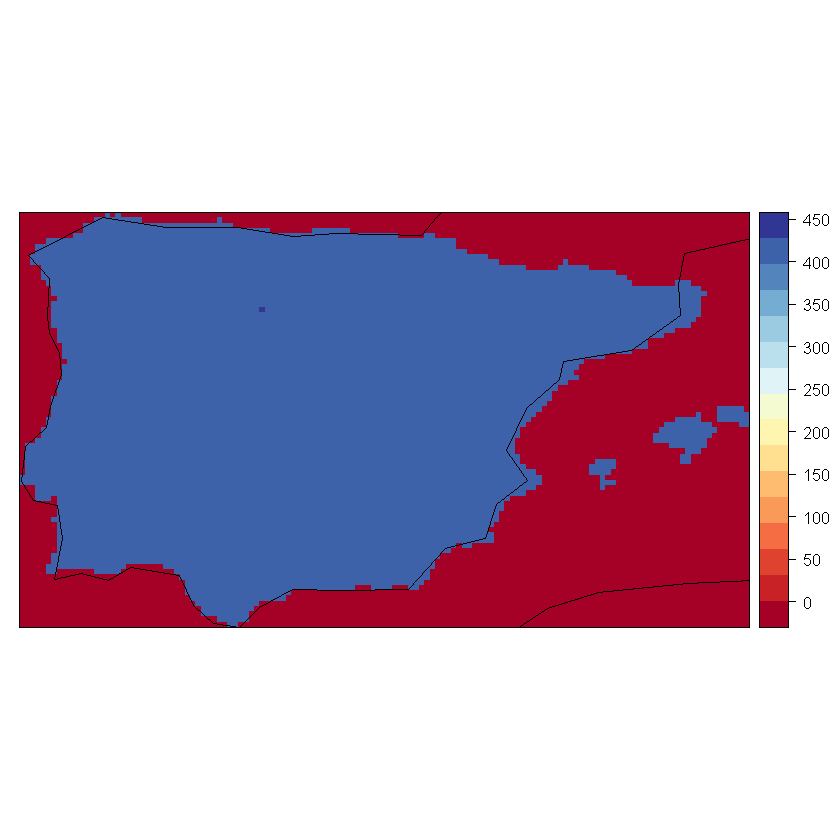

In [24]:
spatialPlot(datosWinter, backdrop.theme = "coastline")

Aplicando la capa tierra

In [25]:
datosWinter_tierra <- gridArithmetics(datosWinter, capa_tierra, operator = "*")

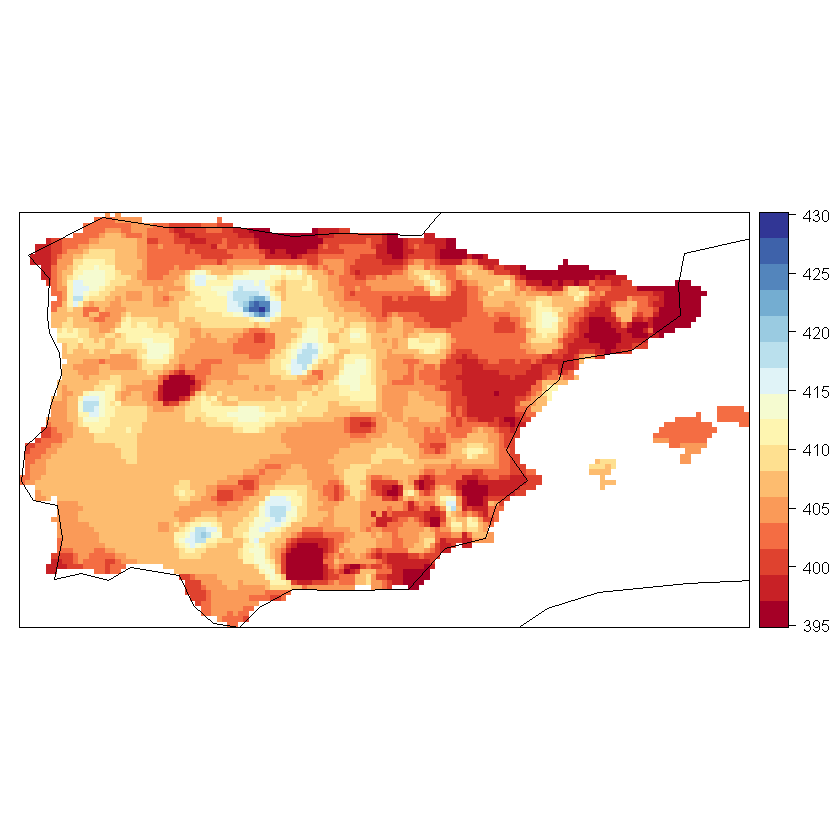

In [26]:
spatialPlot(datosWinter_tierra, backdrop.theme = "coastline")

Bucle para ejecutar todos los datos de todas las estaciones

In [29]:
# Crear un vector con los nombres de las estaciones
estaciones <- c("Winter", "Spring", "Summer", "Autumn")

# Crear una lista para almacenar los resultados
dataPeriod <- list()

# Iterar sobre las estaciones
for (estacion in estaciones) {
  # Obtener los datos para la estación actual
  datos_estacion <- bindGridEstaciones(sum_bin_YS, estacion = estacion)
  datos_estacion <- climatology(datos_estacion, clim.fun = list(FUN = "sum", na.rm = TRUE))
  # datos_estacion <- gridArithmetics(datos_estacion, capa_tierra, operator = "*")
  
  # Almacenar los resultados en la lista
  dataPeriod[[estacion]] <- datos_estacion
}


[2024-03-12 12:01:05] - Computing climatology...
[2024-03-12 12:01:05] - Done.
[2024-03-12 12:01:05] - Computing climatology...
[2024-03-12 12:01:05] - Done.
[2024-03-12 12:01:05] - Computing climatology...
[2024-03-12 12:01:05] - Done.
[2024-03-12 12:01:06] - Computing climatology...
[2024-03-12 12:01:06] - Done.


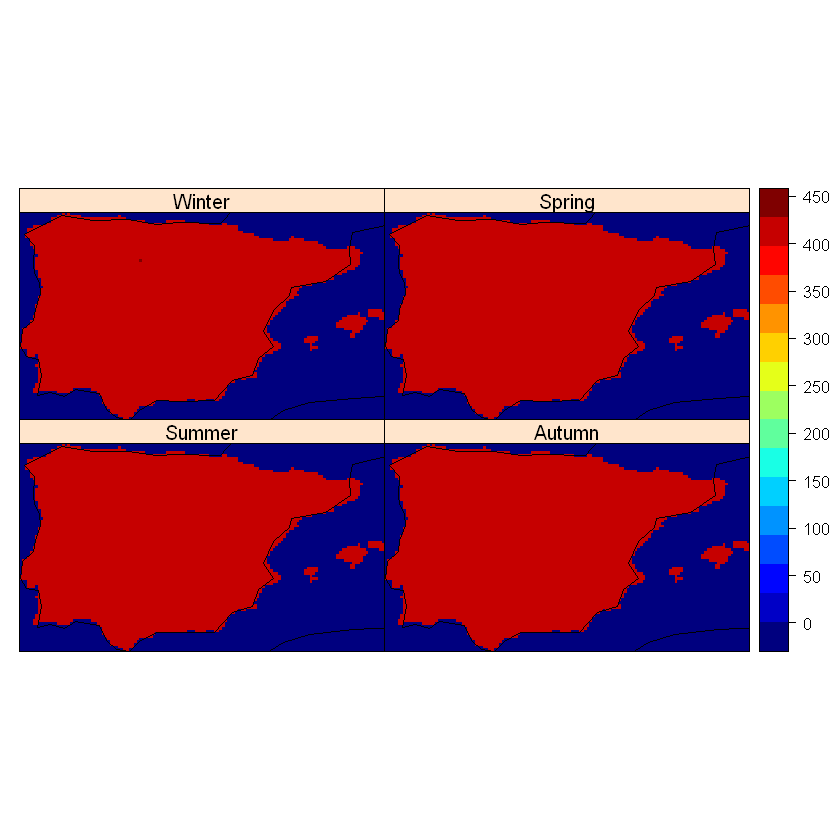

In [30]:
bind <- bindGrid(dataPeriod$Winter, dataPeriod$Spring, dataPeriod$Summer, dataPeriod$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(bind, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), as.table  =TRUE, color.theme = "jet.colors")

CON CAPA TIERRA

In [31]:
# Crear un vector con los nombres de las estaciones
estaciones <- c("Winter", "Spring", "Summer", "Autumn")

# Crear una lista para almacenar los resultados
dataPeriod_tierra <- list()

# Iterar sobre las estaciones
for (estacion in estaciones) {
  # Obtener los datos para la estación actual
  datos_estacion <- bindGridEstaciones(sum_bin_YS, estacion = estacion)
  datos_estacion <- climatology(datos_estacion, clim.fun = list(FUN = "sum", na.rm = TRUE))
  datos_estacion <- gridArithmetics(datos_estacion, capa_tierra, operator = "*")
  
  # Almacenar los resultados en la lista
  dataPeriod_tierra[[estacion]] <- datos_estacion
}

[2024-03-12 12:03:06] - Computing climatology...
[2024-03-12 12:03:06] - Done.
[2024-03-12 12:03:07] - Computing climatology...
[2024-03-12 12:03:07] - Done.
[2024-03-12 12:03:07] - Computing climatology...
[2024-03-12 12:03:07] - Done.
[2024-03-12 12:03:07] - Computing climatology...
[2024-03-12 12:03:08] - Done.


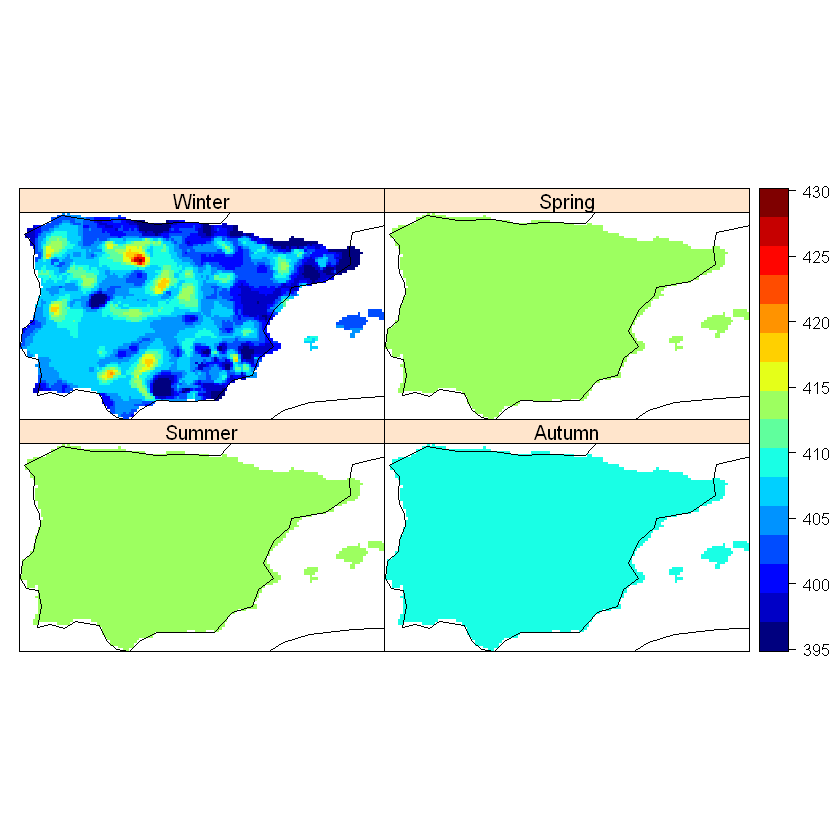

In [32]:
bind_tierra <- bindGrid(dataPeriod_tierra$Winter, dataPeriod_tierra$Spring, dataPeriod_tierra$Summer, dataPeriod_tierra$Autumn, dimension = "member", skip.temporal.check = TRUE)
spatialPlot(bind_tierra, backdrop.theme = "coastline", names.attr = c("Winter", "Spring", "Summer", "Autumn"), as.table  =TRUE, color.theme = "jet.colors")